In [1]:
using Distributed
addprocs(8);

In [2]:
using PulseInputDDM

In [3]:
ncells = [3,3];

In [4]:
ntrials = [100,100];

In [5]:
f = [["Softplus" for n in 1:N] for N in ncells]

2-element Vector{Vector{String}}:
 ["Softplus", "Softplus", "Softplus"]
 ["Softplus", "Softplus", "Softplus"]

In [6]:
n, cross = 53, false

(53, false)

In [7]:
θ_generative = θneural_choice(θz=θz(σ2_i = 5., B = 15., λ = -0.5, σ2_a = 100., σ2_s = 0.5,
    ϕ = 0.4, τ_ϕ = 0.02), bias=1.0, lapse=0.05, θy=[[Softplus(rand([-2., 2.])) for n in 1:N] for N in ncells], 
    f = f);

In [8]:
data, μ_rnt, μ_t = synthetic_data(θ_generative, ntrials, ncells; centered=true, pos_ramp=true, dt_synthetic=1e-4,
    rng=3);

In [9]:
output = PulseInputDDM.process_spike_data.(μ_rnt, data; nconds=2);

In [10]:
μ_ct = getindex.(output, 1)
σ_ct = getindex.(output, 2);

In [11]:
model = neural_choiceDDM(θ_generative, n, cross)  

neural_choiceDDM{θneural_choice{θz{Float64}, Float64, Vector{Vector{Softplus{Float64}}}}}
  θ: θneural_choice{θz{Float64}, Float64, Vector{Vector{Softplus{Float64}}}}
  n: Int64 53
  cross: Bool false


In [12]:
_, μ_c_λ, = simulate_expected_firing_rate(model, data; num_samples=100, nconds=2);

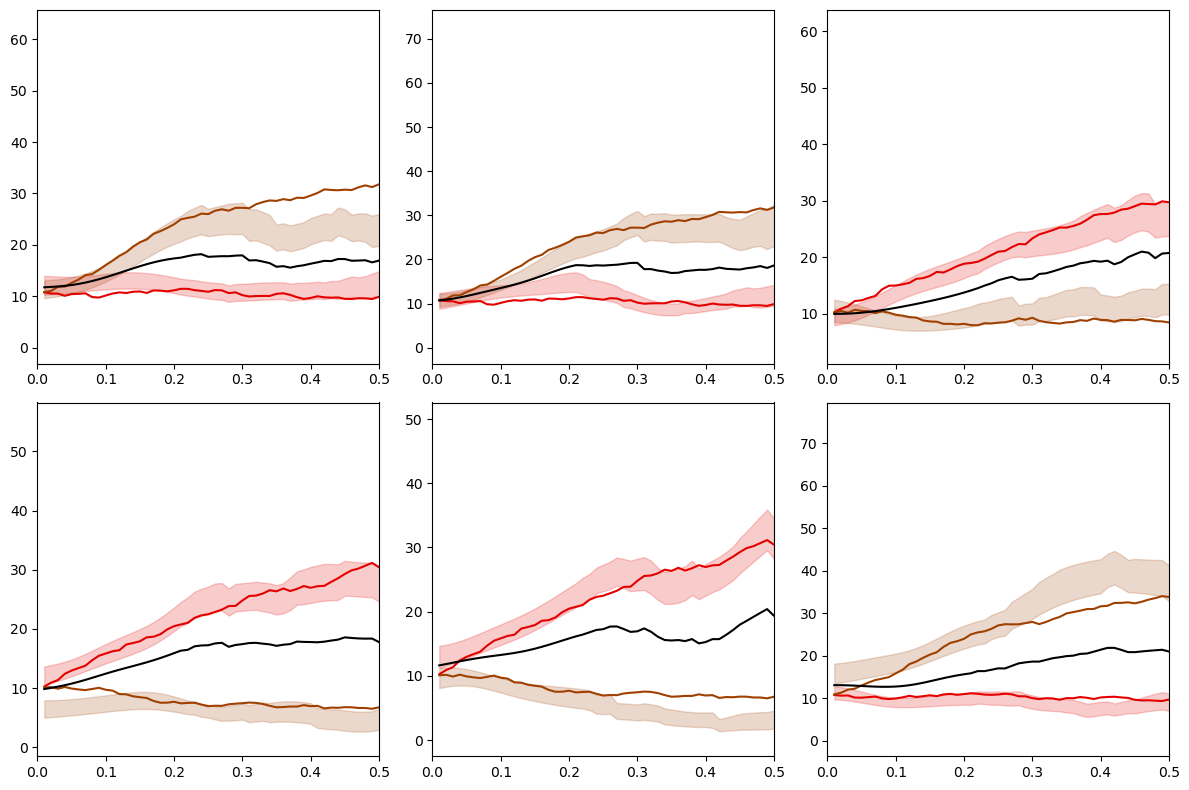

In [13]:
using PyPlot

dt = 1e-2

num_rows, num_cols = length(data), maximum(map(x-> x[1].ncells, data))
fig, ax = subplots(num_rows, num_cols, figsize=(4*maximum(map(x-> x[1].ncells, data)), 4*length(data)))
my_colors = ["#E50000","#9F3F00","#5A7F00","#15BF00"]

for i in 1:num_rows
        
    for j in 1:data[i][1].ncells             
        for k = 1:2     

            ax[i,j].fill_between((1:length(μ_ct[i][j][k]))*dt,
                μ_ct[i][j][k] + σ_ct[i][j][k],
                μ_ct[i][j][k] - σ_ct[i][j][k],
                alpha=0.2, color=my_colors[k])

            ax[i,j].plot((1:length(μ_c_λ[i][j][k]))*dt,
                μ_c_λ[i][j][k], color=my_colors[k])                                     

            ax[i,j].set_xlim((0, 0.5))
                        
        end   
        
        ax[i,j].plot((1:length(μ_t[i][j]))*dt,
            μ_t[i][j], color="black")

    end
    
end

tight_layout()
display(gcf())

In [14]:
options = neural_choice_options(f)
lb, ub, fit = options.lb, options.ub, options.fit
ub[2] = 40.
options = neural_choice_options(fit=fit, lb=lb, ub=ub);

In [15]:
using Flatten

In [16]:
joint_loglikelihood(model, data)

-15579.524502505446

In [17]:
x0 = vcat([0.1, 20., -0.1, 20., 0.8, 0.01, 0.008], 
    [0., 1e-1], vcat(θy.(data, f)...)...);

In [18]:
model = neural_choiceDDM(θneural_choice(x0, f), n, cross)  

neural_choiceDDM{θneural_choice{θz{Float64}, Float64, Vector{Vector{Softplus{Float64}}}}}
  θ: θneural_choice{θz{Float64}, Float64, Vector{Vector{Softplus{Float64}}}}
  n: Int64 53
  cross: Bool false


In [19]:
joint_loglikelihood(model, data)

-16108.152598257802

In [20]:
model, = choice_neural_optimize(model, data, options; iterations=100, outer_iterations=10, f_tol=1e-12, x_tol=1e-12)

Fminbox
-------
Initial mu = 0.0255251

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.0255251

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     1.610710e+04     1.039995e+04
 * time: 0.013097047805786133
    10     1.561318e+04     8.240055e+02
 * time: 55.441555976867676
    20     1.557765e+04     1.151246e+02
 * time: 102.28609609603882
    30     1.557306e+04     3.796590e+00
 * time: 145.57608008384705
    40     1.557267e+04     5.388465e+01
 * time: 189.110435962677
    50     1.557176e+04     4.703910e+01
 * time: 235.40073990821838
    60     1.557039e+04     8.574863e+00
 * time: 278.75309896469116
    70     1.557002e+04     7.849057e-01
 * time: 322.98653411865234
    80     1.557002e+04     1.446107e-02
 * time: 364.98480701446533

Exiting inner optimizer with x = [4.507073197488714, 19.922432681489948, -0.407243430384379, 150.03745128890333, 0.807446229785028, 0.5127189319792611, 0.0209800712729

(neural_choiceDDM{θneural_choice{θz{Float64}, Float64, Vector{Vector{Softplus{Float64}}}}}
  θ: θneural_choice{θz{Float64}, Float64, Vector{Vector{Softplus{Float64}}}}
  n: Int64 53
  cross: Bool false
,  * Status: success

 * Candidate solution
    Final objective value:     1.557130e+04

 * Found with
    Algorithm:     Fminbox with BFGS

 * Convergence measures
    |x - x'|               = 4.44e-07 ≰ 1.0e-12
    |x - x'|/|x'|          = 2.90e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 1.0e-12
    |g(x)|                 = 2.50e-04 ≤ 1.0e-03

 * Work counters
    Seconds run:   651  (vs limit 170000)
    Iterations:    3
    f(x) calls:    184
    ∇f(x) calls:   136
)

In [22]:
hcat(collect(PulseInputDDM.flatten(model.θ)), collect(PulseInputDDM.flatten(θ_generative)))

15×2 Matrix{Float64}:
   4.46358      5.0
  19.8919      15.0
  -0.40844     -0.5
 151.418      100.0
   0.764902     0.5
   0.504823     0.4
   0.0206892    0.02
   0.711752     1.0
   0.0166934    0.05
   1.45693      2.0
   1.52825      2.0
  -1.64835     -2.0
  -1.5364      -2.0
  -1.60515     -2.0
   1.74722      2.0

In [25]:
_, μ_c_λ, = simulate_expected_firing_rate(model, data; num_samples=100, nconds=2);

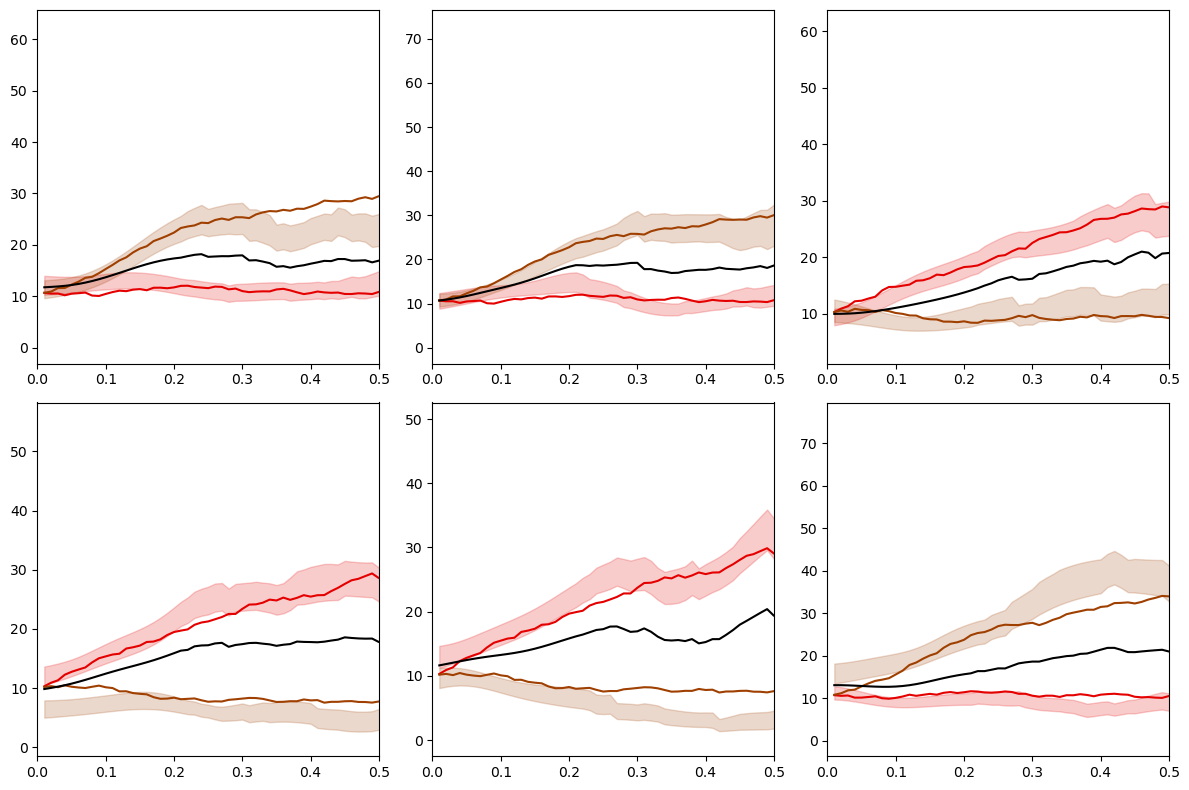

In [26]:
num_rows, num_cols = length(data), maximum(map(x-> x[1].ncells, data))
fig, ax = subplots(num_rows, num_cols, figsize=(4*maximum(map(x-> x[1].ncells, data)), 4*length(data)))
my_colors = ["#E50000","#9F3F00","#5A7F00","#15BF00"]

for i in 1:num_rows
        
    for j in 1:data[i][1].ncells             
        for k = 1:2     

            ax[i,j].fill_between((1:length(μ_ct[i][j][k]))*dt,
                μ_ct[i][j][k] + σ_ct[i][j][k],
                μ_ct[i][j][k] - σ_ct[i][j][k],
                alpha=0.2, color=my_colors[k])

            ax[i,j].plot((1:length(μ_c_λ[i][j][k]))*dt,
                μ_c_λ[i][j][k], color=my_colors[k])                                     

            ax[i,j].set_xlim((0, 0.5))
                        
        end   
        
        ax[i,j].plot((1:length(μ_t[i][j]))*dt,
            μ_t[i][j], color="black")

    end
    
end

tight_layout()
display(gcf())

In [28]:
H = Hessian(model, data)

15×15 Matrix{Float64}:
  0.13537      0.0316249      0.32622   …   -0.667158     0.425737
  0.0316249    0.408598      -0.29258       -0.819098     1.33665
  0.32622     -0.29258       19.8875        -6.80104      6.3534
  0.00902911   0.00099881     0.109268      -0.116077     0.0901471
  0.325859     0.0656903      4.67212       -4.68749      3.55171
 -0.21429     -0.273938      26.8118    …  -15.6831      18.9277
  4.52821      5.92666     -673.663        408.465     -472.249
 -0.00464909  -0.00363779    -0.137131      -0.44785     -0.104525
 -0.0331836    0.139836      -2.62202        1.5044      -0.266371
  0.374597     0.645552       7.49334       -0.0         -0.0
  0.589021     0.760344       6.87726   …   -0.0         -0.0
 -0.397729    -0.834943      -6.587         -0.0         -0.0
 -0.478042    -0.813373      -7.65841      -37.5692      28.09
 -0.667158    -0.819098      -6.80104      114.618       26.0369
  0.425737     1.33665        6.3534        26.0369      96.2873

In [29]:
using LinearAlgebra

In [30]:
eigvals(H)

15-element Vector{Float64}:
      0.00016661240874641623
      0.06078906413749827
      0.15473340878037778
      1.5705782633177248
      2.0591164825501815
     11.225381106513339
     11.627065482448735
     45.689458518732465
     46.951241266462205
    118.56271751134656
    126.38450792949114
    153.17361028937768
    174.34342692563393
   3615.4093972025694
 125492.71286083414

In [32]:
choice_inputs = map(x-> PulseInputDDM.choiceinputs(clicks=x.clicks, binned_clicks=x.binned_clicks, 
    dt=1e-2, centered=false), getfield.(vcat(data...), :input_data));
choice_data = PulseInputDDM.choicedata.(choice_inputs, getfield.(vcat(data...), :choice));
choices = getfield.(choice_data, :choice);

In [57]:
x = PulseInputDDM.flatten(model.θ);

In [35]:
syn_choices = rand.(Ref(Flatten.reconstruct(θchoice(), x[1:9])), choice_inputs, 1:length(choice_inputs));

In [36]:
output = map(x-> binLR(x.click_data.binned_clicks, x.click_data.clicks, x.click_data.dt), choice_data);
L,R = getindex.(output,1), getindex.(output,2);
ΔLR = last.(cumsum.(-L .+ R));

In [37]:
using Optim, LineSearches, ForwardDiff, Distributions
w0 = [0.1, 1., 0.];

In [38]:
mylogit(w) = (w[1]/2 .+ (1 .- w[1]) ./ (1. .+ exp.(-w[2]*ΔLR .+ w[3])));
ll(w) = -1 * sum(logpdf.(Bernoulli.(vec(mylogit(w))), choices))
obj = OnceDifferentiable(ll, w0; autodiff=:forward)
m = BFGS(alphaguess = InitialStatic(alpha=1.0,scaled=true), linesearch = BackTracking());
output = Optim.optimize(obj, [0, -Inf, -Inf], [1., Inf, Inf], w0, Fminbox(m));
what_data = Optim.minimizer(output);

In [39]:
xs = sort(ΔLR);
idxs = sortperm(ΔLR)
y_data = mylogit(what_data)[idxs];

In [40]:
ll(w) = -1 * sum(logpdf.(Bernoulli.(vec(mylogit(w))), syn_choices))
obj = OnceDifferentiable(ll, w0; autodiff=:forward)
output = Optim.optimize(obj, [0, -Inf, -Inf], [1., Inf, Inf], w0, Fminbox(m));
what_syn = Optim.minimizer(output);

In [41]:
y_syn = mylogit(what_syn)[idxs];

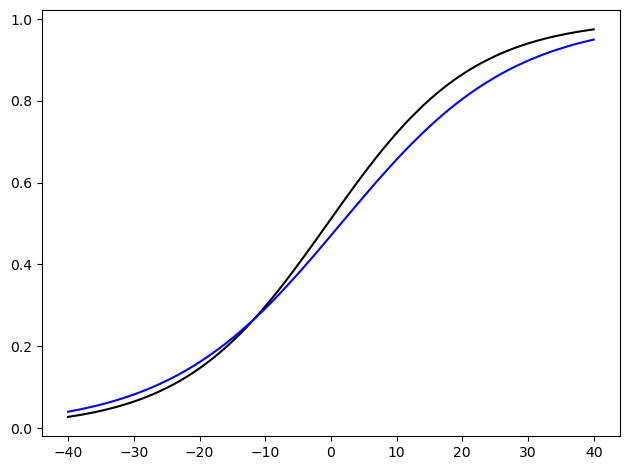

In [56]:
fig, ax = subplots(1, 1)
ax.plot(xs, y_data, label="data", color="black", linestyle="-")
ax.plot(xs, y_syn, label="syn", color="blue", linestyle="-")
tight_layout()
display(gcf())